Ok, there's a lot of feature engineering to be done on this dataset ;-)

Based on the pickup and dropoff location: What's the distance between those two location? What is the nearest weather station for each of these locations ? How far they are from their nearest weather stations ?

Based on pickup and dropoff date and time: What is the day of the trip ? How long does it take ? In which period of the day ? Morning ? Noon ? At night ?

But stop listing all possible features, let's start coding them :-)

In [1]:
# Load my_utils.ipynb in Notebook
from ipynb.fs.full.my_utils import *

Opening connection to database
Add pythagore() function to SQLite engine
Fraction of the dataset used to train models: 10.00%
my_utils library loaded :-)


In [2]:
# Verify SQL tablename is defined in my_utils library
print("Table name used to save the improved dataset:", TRAVEL_TABLENAME)

Table name used to save the improved dataset: travel_improved


In [3]:
# Load NYC travel dataset from SQL database
travel_df=load_sql('travel')

# Display the 3 first rows
travel_df.head(3)

Query: SELECT * FROM travel


,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124


# Adapt data types in timestamp columns

First thing to do is redefine the dtypes of columns:

- pickup and dropoff datetime should be converted into *datetime64* pandas type


In [4]:
# convert pickup_datetime to pandas.datetime[64] type
travel_df['pickup_datetime']=pd.to_datetime(travel_df['pickup_datetime'])

# convert dropoff_datetime to pandas.datetime[64] type
travel_df['dropoff_datetime']=pd.to_datetime(travel_df['dropoff_datetime'])

# Verify the change
travel_df[['pickup_datetime','dropoff_datetime']].dtypes

pickup_datetime     datetime64[ns]
dropoff_datetime    datetime64[ns]
dtype: object

# Date and Time features

## Day of the trip ? Weekday ? Weekend ?

Based on the *pickup_datetime* feature, let's build categorical columns that will define:
- If trip started on a weekday (Monday to Friday)
- If trip started on week-end (Saturday or Monday)

I will used the *Series.dt.dayofweek* property that returns the day of the week with Monday=0, Sunday=6 to build a new *travel_weekday* categorical feature.

> Note: the *is_weekend()* method is coded in the *my_utils* library

In [5]:
# Apply is_weekend() function to pickup_datetime feature and store result in 'weekend' column
travel_df['weekend']=travel_df['pickup_datetime'].apply(is_weekend)

# Display result
travel_df[['pickup_datetime','weekend']].head(3)

,pickup_datetime,weekend
0,2016-03-14 17:24:55,0
1,2016-06-12 00:43:35,1
2,2016-01-19 11:35:24,0


## Create bins with the time the trip begins: morning, afternoon, evening, night

I've decided to use the *pickup_datetime* feature to create a new categorical feature wich classify the travels in 4 different categories, depending on the time of start:

| Category  | Trips starts between |
|-----------|:--------------------:|
| morning   | 6:00 and 12:00       |
| afternoon | 12:00 and 18:00      |
| evening   | 18:00 and 22:00      |
| night     | 22:00 and 6:00.      |

I will use *apply()* and *get_dummies()* method from *pandas* to build new categorical features.

> Note: The *get_time_category()* is coded in the *my_utils* library

In [6]:
# apply get_time_category on pickup_datetime feature
travel_df['day_period']=travel_df['pickup_datetime'].apply(get_time_category)

# use get_dummies() to. build categorical features
travel_df=pd.get_dummies(travel_df, columns=['day_period'])

# Drop one of the column (useless)
travel_df.drop('day_period_night', axis=1, inplace=True)

# Display three first rows
travel_df[['pickup_datetime','day_period_morning','day_period_afternoon','day_period_evening']].head(3)


,pickup_datetime,day_period_morning,day_period_afternoon,day_period_evening
0,2016-03-14 17:24:55,0,1,0
1,2016-06-12 00:43:35,0,0,0
2,2016-01-19 11:35:24,1,0,0


## Create a column with day of the trip (YYYY-MM-DD)

Even if it looks useless to create a new column made of the date part of the *pickup_datetime*, I will use this column to join lines between the *travel* and the *weather_cat* datasets.

The merge between those two dataset will be done in the [Global Dataset - Merging all the datasets into a big one](17.The%20global%20Dataset%20-%20Merging%20all%20the%20datasets%20into%20a%20big%20one.ipynb) Notebook

In [7]:
# Apply lambda function on pickup_datetime to build pickup_date columns
travel_df['pickup_date']=travel_df['pickup_datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))

# Display result
travel_df[['pickup_datetime', 'pickup_date']].head(5)

,pickup_datetime,pickup_date
0,2016-03-14 17:24:55,2016-03-14
1,2016-06-12 00:43:35,2016-06-12
2,2016-01-19 11:35:24,2016-01-19
3,2016-04-06 19:32:31,2016-04-06
4,2016-03-26 13:30:55,2016-03-26


# Distance Features

### Calculate the distance bewtween pickup and dropoff in kilometers

In order to build the dependent feature, the average speed of a TAXI travel, I am missing the distance between pickup and dropoff location.

To obtain it, I'll use a function that will calculate, for each travel, the distance between those two locations.

How ?

Using a function, *get_distance_in_km()*, that will calculate the distance between two locations from their latitude/longitude coordinates. Of course, the distance obtained here is the straight line distance between the two points, not the effective distance driven by the TAXI.


> Note: The function *get_distance_in_km()* is coded in the [my_utils](my_utils.ipynb) library


In [8]:
# Build distance_km feature column
travel_df['distance_in_km']=get_distance_in_km(
    travel_df['pickup_latitude'],
    travel_df['pickup_longitude'],
    travel_df['dropoff_latitude'],
    travel_df['dropoff_longitude']
)

# display result
travel_df[['distance_in_km','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].head(3)


,distance_in_km,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,1.498521,40.767937,-73.982155,40.765602,-73.964630
1,1.805507,40.738564,-73.980415,40.731152,-73.999481
2,6.385098,40.763939,-73.979027,40.710087,-74.005333


To be sure that my function returns the right value, I've picked-up an example from my dataset and used Google Maps to measure the distance.

**Value from my Dataset used for control: 6.39 km**

|                   |            |
|-------------------|:----------:|
|pickup_latitude    | 40.763939  |
|pickup_longitude   | -73.979027 |
|dropoff_latitude   | 40.710087  |
|dropoff_longitude  | -74.005333 |
|distance_in_km     | 6.39 km    |

**Value obtained from [Google Maps](https://www.google.com/maps/dir/40.763939%09-73.979027/40.710087%09-74.005333/@40.745115,-74.0060109,13.66z/data=!4m10!4m9!1m3!2m2!1d-73.979027!2d40.763939!1m3!2m2!1d-74.005333!2d40.710087!3e0): 6.42 km**

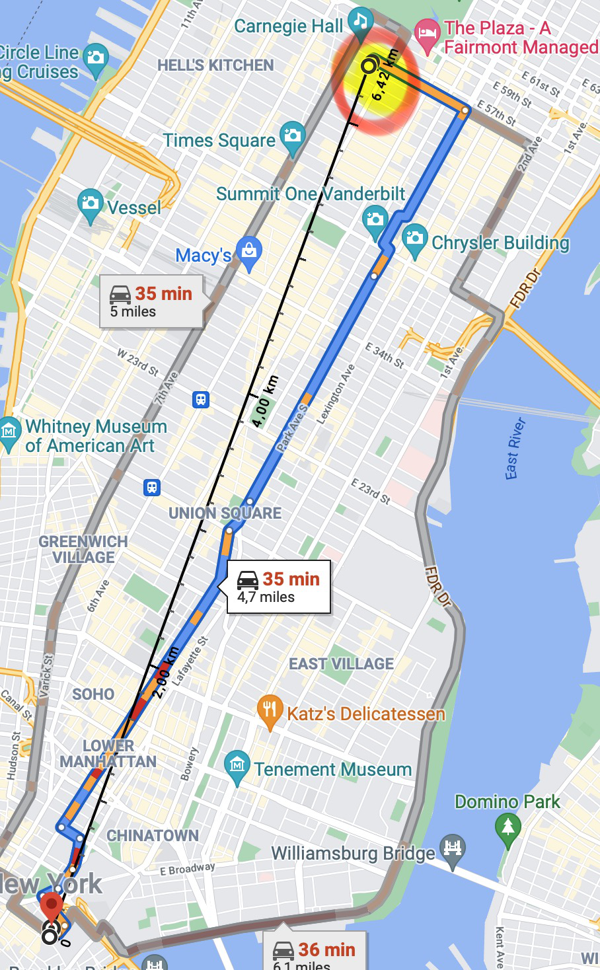

In [9]:
img=Image.open(os.path.join(IMG_PATH, 'distance-between-two-locations.jpg'))
img.thumbnail([600,1000]);img

Google Maps link where the measure has been done: [From (40.763939,-73.979027) to (40.710087,-74.005333)](https://www.google.com/maps/dir/40.763939%09-73.979027/40.710087%09-74.005333/@40.745115,-74.0060109,13.66z/data=!4m10!4m9!1m3!2m2!1d-73.979027!2d40.763939!1m3!2m2!1d-74.005333!2d40.710087!3e0)

## Calculate the average speed to go from pickup to dropoff location

Now, having the distance between pickup and dropoff, it's possible to build my dependent feature: the TAXI Travel Speed between pickup and dropoff location.

Simply divide the *distance_in_km* by the *trip_duration* and multiply the result by *3'600* to obtain a speed value in kilometers per hour.

> Note: Remember, the *distance_in_km* feature is the *straight line* distance between pickup and dropoff location, speed calculated here is not the real TAXI speed.


In [10]:
# Build travel speed feature column in km per hour (multiply by 3600 seconds)
travel_df['km_per_hour']=travel_df['distance_in_km']/travel_df['trip_duration']*3600
travel_df.head(5)

# display result
travel_df[['km_per_hour', 'distance_in_km', 'trip_duration']].head(3)

,km_per_hour,distance_in_km,trip_duration
0,11.856428,1.498521,455
1,9.803659,1.805507,663
2,10.822201,6.385098,2124


As expected, the result here shows a quite strong correlation between *trip_duration* and *distance_in_km*

Let's drop the *trip_duration* feature.

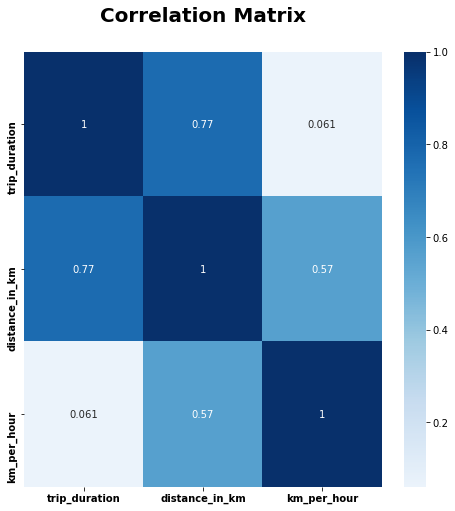

In [11]:
# Show correlation matrix between trip_duration, distance_in_km and km_per_hour
draw_correlation_matrix(travel_df[['trip_duration', 'distance_in_km', 'km_per_hour']], figsize=(8,8))


In [12]:
# Drop trip_duration column
travel_df.drop('trip_duration', axis=1, inplace=True)

## Travel speed outliers

Now that my dependent variable has been defined, looking at its values shows some outliers that I was not able to detect before without calculating distance and speed.

Here is an histogram of speed valuoes that are above 100 kilometers, at bit high in my opinion in NYC ;-)

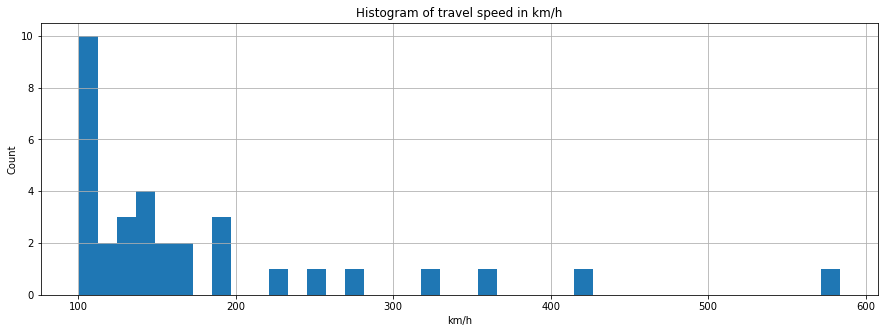

,pickup_datetime,dropoff_datetime,distance_in_km,km_per_hour
1049962,2016-03-20 11:47:20,2016-03-20 11:49:21,19.619959,583.734313


In [13]:
# Show histogram of speed value higher than 100 km/h
plt.figure(figsize=(15,5))
travel_df[travel_df.km_per_hour > 100]['km_per_hour'].hist(bins=40)
plt.title("Histogram of travel speed in km/h")
plt.xlabel("km/h")
plt.ylabel("Count")
plt.show()
travel_df[travel_df.km_per_hour > 500][['pickup_datetime', 'dropoff_datetime', 'distance_in_km', 'km_per_hour']]

Wow !!! 583 km/h in New-York :-)

On the opposite side, I've found some trips with 0 km, which implies trip speed of 0 km/h.

I should drop those abnormal values.

Question: What is an  *abnormal speed* ?

Well, there's no really good answer, I have to choose some arbitrary values.

To help me in my choices, I will use an histogram of the *np.log10()* values, removing *abnormal one*, and search the *min* and *max* values that gives an histigram with the most perfect Gauss curve.

Doing this exercise, I've found that good values *could* be travel speed between 3 and 50 km/h

Lines in dataset where travel speed is outside this speed limit will be dropped.

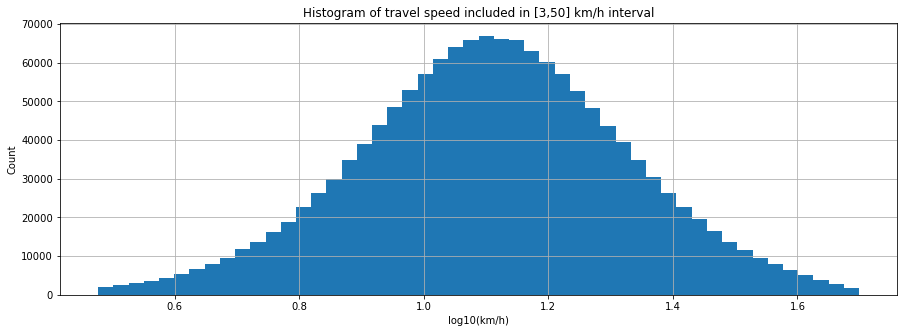

In [14]:
SPEED_LIMIT_LOW=3
SPEED_LIMIT_HIGH=50

filter_travel_speed=np.logical_and(
    travel_df.km_per_hour >= SPEED_LIMIT_LOW,
    travel_df.km_per_hour <= SPEED_LIMIT_HIGH
)
plt.figure(figsize=(15,5))
np.log10(travel_df[filter_travel_speed]['km_per_hour']).hist(bins=50)
plt.title("Histogram of travel speed included in [3,50] km/h interval")
plt.xlabel("log10(km/h)")
plt.ylabel("Count")
plt.show()

How many lines will be dropped using this Travel speed limit ?

In [15]:
print("Number of lines removed using the Travel speed interval [{},{}]: {}".format(
    SPEED_LIMIT_LOW,
    SPEED_LIMIT_HIGH,
    travel_df[~filter_travel_speed]['km_per_hour'].count()
))

Number of lines removed using the Travel speed interval [3,50]: 21228


Number of lines removed is acceptable, I decide to keep this speed interval and drop trips that are outside of it.

> Note: Later in the [Global Dataset - Merging all the datasets into a big one](17.The%20global%20Dataset%20-%20Merging%20all%20the%20datasets%20into%20a%20big%20one.ipynb) Notebook, I will normalize the *km_per_hour* field using *np.log10()* method.


In [16]:
# Remove outliers
travel_df=travel_df[filter_travel_speed]

# Passenger numbers, from numerical to categorical

Looking at the passenger numbers distribution in TAXI Travel, I've decided to transform this numerical value into a categorical one:

- Is there more than 1 passenger in the trip ?

This is simply done using *apply()* method on the *passenger_count* feature with a lambda function that returns 1 if passenger numbers is higher than 1:

In [17]:
# Transform passenger to a categorical one
travel_df['passenger_alone']=travel_df['passenger_count'].apply(lambda x: 0 if x>1 else 1)

# Drop passenger_count feature
travel_df.drop('passenger_count', axis=1, inplace=True)

# Travel and weather station static data join

The goal here is to map all the pickup and dropoff location of the *travel* dataset with their nearest weather station.

When this is done, I will calculate, again for pickup and dropoff, the distance in km from the nearest weather station found.

And finally, with travel and weather station mapped together, I'll be able to create new features:

- The elevation difference between pickup and dropoff (numerical feature)
- The elevation from pickup to dropoff is ascending or descending (categorical feature)


## Map pickup and dropoff point to their nearest weather station

Ok, something really fun to do: Find the nearest weather station of the pickup and dropoff location.

To do so, I've created a function *get_nearest_station_from_location* in [my_utils](my_utils.ipynb) library that seeks in the 83 weather stations dataset which station is the nearest from a location passed as parameter (see [my_utils](my_utils.ipynb) for more informations on that function implementation)

Then, I've used this function in combination with the *DataFrame.apply()* method to deetermine, for each rows in my *travel* dataset, which are the nearest weather stations for each pickup and dropoff locations.

**WARNING !!** This process results in heavy computing: 1'500'000 cells have to be processed, each of them requiring 83 calls to a *pythagore()* function which includes heavy calculus.  It tooks about 15 minutes on my Apple Mac M1 computrer. So be patient ;-)

After processing each slices, the result will be appended in a *temporary* table of the database. This table will be reloaaded at the end of the process to be saved back and replace values into the *TRAVEL_TABLENAME* table.

> Note 1: As the quantity of data to be manipulated is quite high, in order to avoid any limit problems, I've made the following process working on slices of the dataset, splitting it by slices of 100'000 lines. I've coded a function named *get_slice_list()* that returns a list of tuples of slice indexes. This function *get_slice_list()* is detailed in the [my_utils](my_utils.ipynb) library

> Note 2: The name of the features created by joining *travel* and *stations* data, pickup_STATION and dropoff_STATION, uses lowercase and uppercase. Lowercase indicates features coming from *travel* dataset, uppercase from *weather* one. Now you understand the reason why I kept lowercase and uppercase in the feature names of each dataset, a sort of visual mnemonic to quickly identify from where the feature comes from. This will be more usefull when I'll build the full joined dataset in [The global Dataset - Merging all the datasets into a big one](17.The%20global%20Dataset%20-%20Merging%20all%20the%20datasets%20into%20a%20big%20one.ipynb)

In [18]:
# Print list of interval tuples for the travel_df dataset using get_slice_list() from my_utils
print("List of slices calculated for the travel_df dataset:")
print(get_slice_list(travel_df, slice_interval=250000))


List of slices calculated for the travel_df dataset:
[(0, 249999), (250000, 499999), (500000, 749999), (750000, 999999), (1000000, 1249999), (1250000, 1426415)]


In [19]:
# measure processing time (for fun)
import time

# Drop temporary database
drop_table(tablename='temporary')

# start global timer
global_start=time.time()

print("== Start processing dataset ==")
# Work on slices of dataset to avoid memory limitations
for interval in get_slice_list(dataset=travel_df, slice_interval=250000):

    print("Working on slice", interval)
    # Get dataset slice
    df=travel_df[interval[0]:interval[1]+1].copy()
    print(  "Number of lines to process: ", len(df.index))


    # Search nearset weather stations for pickup and dropoff
    for i in ['pickup', 'dropoff']:
        # start timer
        start = time.time()

        # Start processing
        print(f" Processing {i} locations...")

        # Find nearest stations for interval
        df[f'{i}_STATION']=df[[f'{i}_latitude', f'{i}_longitude']].apply(lambda x: get_nearest_station_from_location(x[f'{i}_latitude'], x[f'{i}_longitude']), axis=1)
        
        # stop timer
        end = time.time()
        print("   => Processing time for {}: {:.2f} minutes".format(i, (end - start)/60))

    # Append to SQL database table
    print(" Save to database...")
    save_sql(dataset=df, tablename='temporary', if_exists='append')
    
    print(f"-- Slice {interval} done --")

    
# Stop global timer
global_end=time.time()

# Display processing time
print("== Processing terminated. Total time: {:.2f} minutes ==".format((global_end - global_start)/60))



'temporary' table dropped from SQL database
== Start processing dataset ==
Working on slice (0, 249999)
Number of lines to process:  250000
 Processing pickup locations...
   => Processing time for pickup: 4.01 minutes
 Processing dropoff locations...
   => Processing time for dropoff: 3.91 minutes
 Save to database...
Saving OK
-- Slice (0, 249999) done --
Working on slice (250000, 499999)
Number of lines to process:  250000
 Processing pickup locations...
   => Processing time for pickup: 4.01 minutes
 Processing dropoff locations...
   => Processing time for dropoff: 4.04 minutes
 Save to database...
Saving OK
-- Slice (250000, 499999) done --
Working on slice (500000, 749999)
Number of lines to process:  250000
 Processing pickup locations...
   => Processing time for pickup: 3.92 minutes
 Processing dropoff locations...
   => Processing time for dropoff: 3.91 minutes
 Save to database...
Saving OK
-- Slice (500000, 749999) done --
Working on slice (750000, 999999)
Number of lines 

### Save result in database

Ok, now that the complete result is stored in the SQL *temporary* table, reload it, replace the *travel_df* variable, and save it back to the SQL databse.

This new version of the *travel_df* dataset is the one that I'll use in the rest of this Notebook.

In [20]:
# Reload travel_df from 'temporary' table
travel_df=load_sql('temporary')

# and save it back to SQL database
save_sql(dataset=travel_df, tablename=TRAVEL_TABLENAME)

Query: SELECT * FROM temporary
Saving OK


True

### Visual check of the result

Let's do scatter plots of *pickup* and *dropoff* locations using different colors for each weather station locations they are associated with.

> Note: I've removed the legend as the number of stations is a bit too high to be added on the graph

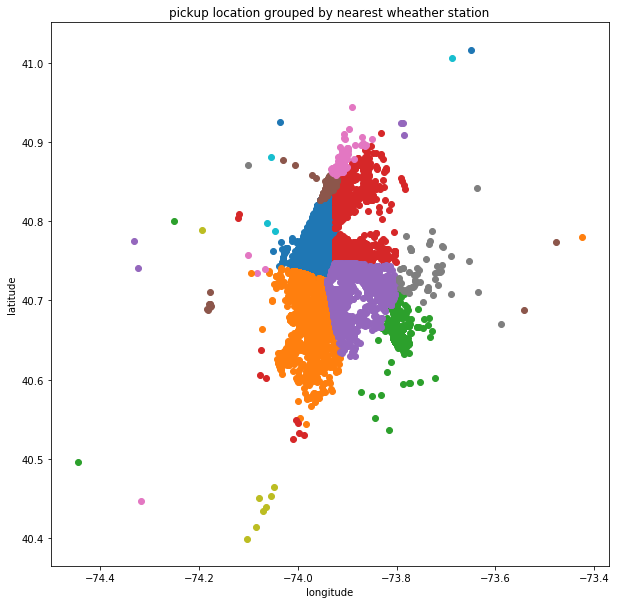

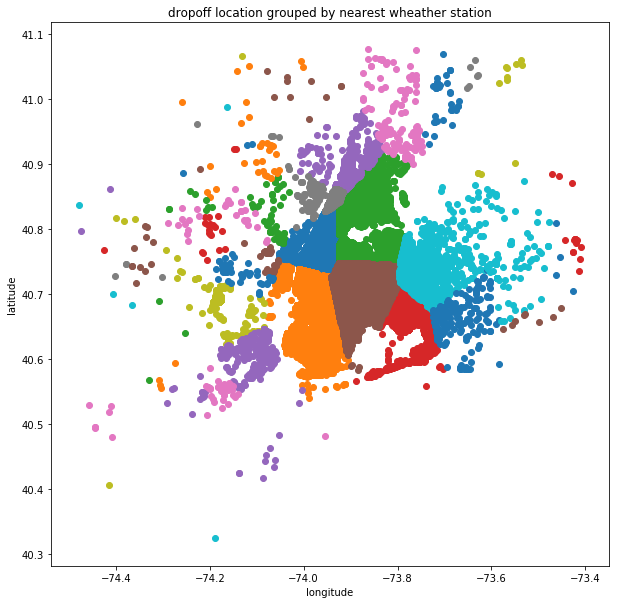

In [21]:
# Print two graphs, one for pickup, the other for dropoff
for i in ['pickup', 'dropoff']:

    # Set figure size
    plt.figure(figsize=(10,10))

    # Loop for each station found in pickup_STATION feature
    for station in list(travel_df[f'{i}_STATION'].unique()):

        # Get the True/False selection Series filtering on the statio name
        idx = (travel_df[f'{i}_STATION'] == station)

        # Scatter plot of locations concerned by the current weather station
        plt.scatter(travel_df[idx][f'{i}_longitude'], travel_df[idx][f'{i}_latitude'], label=station)

    # Add title
    plt.title(f'{i} location grouped by nearest wheather station')

    # Set Y and Y axis labels
    plt.xlabel('longitude')
    plt.ylabel('latitude')

    # Display canvas
    plt.show()

### Remark

Looking at the previous graphs, I can find that pickup locations are more *localized* on the center of the map, while *dropoff* one *spread* more far from that center.



## Calculate the distance between pickup and dropoff location with their nearest weather station

One feature that could be interesting would be to calculate the distance between pickup and dropoff location and their nearest weather station.

I will do this using SQL query with *INNER JOIN* approach.


In [22]:
# Build a select function with two INNER JOIN between travel and stations datasets, one INNER JOIN per pickup/dropoff location
query='SELECT '
query+='T.pickup_latitude, T.pickup_longitude, pickup_STATION, P.LATITUDE as pickup_STATION_LATITUDE, P.LONGITUDE AS pickup_STATION_LONGITUDE,'
query+='T.dropoff_latitude, T.dropoff_longitude, dropoff_STATION, D.LATITUDE as dropoff_STATION_LATITUDE, D.LONGITUDE AS dropoff_STATION_LONGITUDE '
query+=f'FROM {TRAVEL_TABLENAME} as T '
query+='INNER JOIN stations as P ON T.pickup_STATION=P.STATION '
query+='INNER JOIN stations as D ON T.dropoff_STATION=D.STATION '

df=load_sql(query=query)

for i in ['pickup', 'dropoff']:
    travel_df[f'{i}_distance_to_STATION']=get_distance_in_km(df[f'{i}_latitude'], df[f'{i}_longitude'], df[f'{i}_STATION_LATITUDE'], df[f'{i}_STATION_LONGITUDE'])

travel_df[['pickup_distance_to_STATION', 'dropoff_distance_to_STATION']].head(3)


Query: SELECT T.pickup_latitude, T.pickup_longitude, pickup_STATION, P.LATITUDE as pickup_STATION_LATITUDE, P.LONGITUDE AS pickup_STATION_LONGITUDE,T.dropoff_latitude, T.dropoff_longitude, dropoff_STATION, D.LATITUDE as dropoff_STATION_LATITUDE, D.LONGITUDE AS dropoff_STATION_LONGITUDE FROM travel_improved as T INNER JOIN stations as P ON T.pickup_STATION=P.STATION INNER JOIN stations as D ON T.dropoff_STATION=D.STATION 


,pickup_distance_to_STATION,dropoff_distance_to_STATION
0,1.639747,1.537584
1,4.591445,5.287223
2,1.864153,3.240232


Displaying the histogram of those two new features shows that we have some outliers here, but anyway, for this feature, I decide to keep them in the dataset.

pickup distance to STATION
count    1426415
mean           3
std            1
min            0
25%            1
50%            2
75%            4
max           17
Name: pickup_distance_to_STATION, dtype: int64


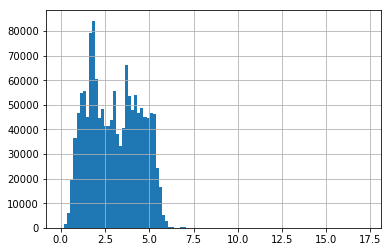

------
dropoff distance to STATION
count    1426415
mean           3
std            1
min            0
25%            1
50%            3
75%            4
max           18
Name: dropoff_distance_to_STATION, dtype: int64


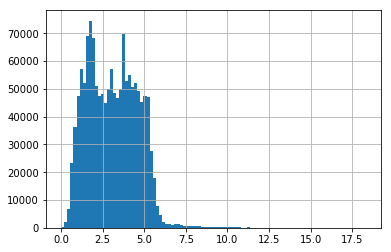

------


In [23]:
# Describe feature (using 'int' dtype) and draw histogram (bins=100)
for i in ['pickup','dropoff']:
    print(f'{i} distance to STATION')
    print(travel_df[f'{i}_distance_to_STATION'].describe().astype('int'))
    travel_df[f'{i}_distance_to_STATION'].hist(bins=100)
    plt.show()
    print('------')

### Save dataset

It's time to overwrite the table in our SQL database with this new improved *travel* dataset

In [24]:
# Save travel_df to SQL database
save_sql(travel_df, tablename=TRAVEL_TABLENAME)

Saving OK


True

## Elevation feature

#### Absolute elevation difference between pickup and dropoff, ascending or descending trip

Now that pickup and dropoff locations have their nearest weather stations set, I can use the *ELEVATION* feature of the stations to calculate the elevation difference between pickup and dropoff location.

I'll store those informations in a new feature numerical feature:

- diff_ELEVATION

At the same time, I will build two categorical feature that will describe if the trip is going from pickup to dropoff ascending, *diff_ELEVATION* value is positive, or descending, *diff_ELEVATION* is a negative value.

- diff_ASCENDING: Set to 1 if the difference between the dropoff *ELEVATION* and the pickup one is absolutely positive ( > 0 ), 0 otherwise.
- diff_DESCENDING: Set to 1 if the difference between the dropoff *ELEVATION* and the pickup one is absolutely negative ( < 0 ), 0 otherwise.

> Note : if *diff_ASCENDING* and *diff_DESCENDING* are both equal to 0, this means that the travel starts and ends at the same *ELEVATION* value. This *zero ELEVATION* feature is useless (completly correlated with the two others) and not stored in the dataset.


In [25]:
# Build a select function with two INNER JOIN between travel and stations datasets, one INNER JOIN per pickup/dropoff location to find elevation of the nearest STATION
# and calculate the absolute difference between pickup and dropoff elevation (based on the ELEVATION of the nearest STATION)
query='SELECT '
query+='P.ELEVATION AS pickup_ELEVATION, D.ELEVATION AS dropoff_ELEVATION '
query+=f'FROM {TRAVEL_TABLENAME} as T '
query+='INNER JOIN stations as P ON T.pickup_STATION=P.STATION '
query+='INNER JOIN stations as D ON T.dropoff_STATION=D.STATION '

# Load query as dataset
df=load_sql(query=query)

# Build diff_ELEVATION feature
travel_df['diff_ELEVATION']=np.abs(df['pickup_ELEVATION']-df['dropoff_ELEVATION'])

# build diff_ASCENDING feature
travel_df['diff_ASCENDING']=(df['dropoff_ELEVATION']-df['pickup_ELEVATION']).apply(lambda x: 1 if x > 0 else 0)

# build diff_DESCENDING feature
travel_df['diff_DESCENDING']=(df['dropoff_ELEVATION']-df['pickup_ELEVATION']).apply(lambda x: 1 if x < 0 else 0)

# Display 5 first rows of our dataset
travel_df[['diff_ELEVATION', 'diff_ASCENDING', 'diff_DESCENDING']].head(5)
    



Query: SELECT P.ELEVATION AS pickup_ELEVATION, D.ELEVATION AS dropoff_ELEVATION FROM travel_improved as T INNER JOIN stations as P ON T.pickup_STATION=P.STATION INNER JOIN stations as D ON T.dropoff_STATION=D.STATION 


,diff_ELEVATION,diff_ASCENDING,diff_DESCENDING
0,0.0,0,0
1,37.2,0,1
2,37.2,0,1
3,0.0,0,0
4,0.0,0,0


# Save result to database and...

In [26]:
save_sql(travel_df, tablename=TRAVEL_TABLENAME)

Saving OK


True

...follow up with the next Notebook: [NYC Weather Categorical Dataset Feature Engineering](15.NYC%20Weather%20Categorical%20Dataset%20Feature%20Engineering.ipynb)